In [ ]:
import torch
import numpy as np

import os
os.chdir('..')
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load
from evaluate import evaluate_model, pp_output
import instance_generator as ig
import torch_converter as tc
import evaluate as ev
import osmnx as ox
from util import Dataset

%load_ext autoreload
%autoreload 2

: 

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 1.12.0+cu102
Using device: cuda:0


In [3]:
def define_model(trial):
    args = {
        'processor':         'GENConv',
        'head':              'regression',
        'num_layers':        trial.suggest_int("num_layers{}", 1, 6),
        'num_mlp_layers':    trial.suggest_int("num_mlp_layers{}", 2, 5), # TODO set to larger
        'aggr':              'max',
        'batch_size':        2**trial.suggest_int("log_batch_size", 1, 6), 
        'node_feature_dim':  4,
        'edge_feature_dim':  1,
        'graph_feature_dim': 2,
        'hidden_dim':        2**trial.suggest_int("hidden_dim", 1, 7), # TODO set to 128
        'output_dim':        1,
        'dropout':           trial.suggest_float("dropout", 0, 0.5),
        'epochs':            trial.suggest_int("epochs", 5, 100), # TODO set to larger
        'opt':               trial.suggest_categorical("optimizer", ["adam", "adagrad"]),
        'opt_scheduler':     'none',
        'opt_restart':       0,
        'weight_decay':      5e-3, # TODO possibly modify
        'lr':                trial.suggest_float("lr", 1e-5, 1e-1, log=True),
        'device':            device
    }
    return args

In [4]:
def objective(trial):
	args = define_model(trial)
	train_num = 100; test_num = 30

	er_config = {
	'graph_type': 'ER',
	'p': 1,
	'weighted': True
	}
	ba_config = {
	'graph_type': 'BA',
	'ba_param': 2,
	'weighted': True
	}
	geom_config = {
	'graph_type': 'GEOM',
	'threshold': 0.2,
	'scaling': 1 / np.sqrt(2)
	}

	rng = np.random.default_rng()


	train_instances = [
		*ig.sample_instances(9, 7, train_num, rng, **er_config),
		*ig.sample_instances(9, 7, train_num, rng, **ba_config),
		*ig.sample_instances(9, 7, train_num, rng, **geom_config),
	]

	test_instances = [
		*ig.sample_instances(9, 7, test_num, rng, **er_config),
		*ig.sample_instances(9, 7, test_num, rng, **ba_config),
		*ig.sample_instances(9, 7, test_num, rng, **geom_config),
	]


	train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
	test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

	train_loader = DataLoader(
	train_data,
	batch_size=args['batch_size'],
	shuffle=True,
	num_workers=4
	)

	test_loader = DataLoader(
	test_data,
	batch_size=args['batch_size'],
	shuffle=True,
	num_workers=4
	)

	### Training

	_, _, test_accuracies, GNN, _ = train(train_loader, test_loader, args, trial)
	return test_accuracies[-1]

In [5]:
import optuna
from optuna.trial import TrialState

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500, timeout=60000)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
	print("    {}: {}".format(key, value))


[I 2024-01-13 09:15:15,609] A new study created in memory with name: no-name-1db4720c-fd92-4f21-96ea-12bb553392af
Training:   0%|          | 0/51 [00:00<?, ?Epochs/s]/home/alexhay/.local/lib/python3.10/site-packages/torch_geometric/utils/scatter.py:93: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(f"The usage of `scatter(reduce='{reduce}')` "
Training: 100%|██████████| 51/51 [02:24<00:00,  2.84s/Epochs]
[I 2024-01-13 09:17:50,509] Trial 0 finished with value: 0.6881720423698425 and parameters: {'num_layers{}': 3, 'num_mlp_layers{}': 3, 'log_batch_size': 5, 'hidden_dim': 12, 'dropout': 0.4734006881921554, 'epochs': 51, 'optimizer': 'rmsprop', 'lr': 4.023110050071799e-05}. Best is trial 0 with value: 0.6881720423698425.
Training: 100%|██████████| 29/29 [00:58<00:00,  2.02s/Epochs]
[I 2024-01-13 09:18:55,463] Trial 1 finished with value: 0.8659638166427612 and parameters: {'num_layers{}': 4, 'num_

Study statistics: 
  Number of finished trials:  500
  Number of pruned trials:  454
  Number of complete trials:  46
Best trial:
  Value:  0.9181102514266968
  Params: 
    num_layers{}: 4
    num_mlp_layers{}: 2
    log_batch_size: 3
    hidden_dim: 58
    dropout: 0.06566594164473301
    epochs: 80
    optimizer: adagrad
    lr: 0.0022434305890468857


In [5]:
# save(GNN, args, 'GNN3')

In [4]:
GNN, args = load('GNN1', device)

# Pivot to feature-generated graphs

In [4]:
def get_location_graph(city):
	location_graph = ox.graph_from_place(city, network_type="drive")
	location_graph = ox.speed.add_edge_speeds(location_graph)
	location_graph = ox.speed.add_edge_travel_times(location_graph)
	return {'location_graph': location_graph, 'city': city}

In [8]:
piedmont = get_location_graph("Piedmont, California, USA")
# san_francisco = get_location_graph("San Francisco, California, USA")
founex = get_location_graph("Founex, Switzerland")
carmel = get_location_graph("Carmel, Indiana, USA")
geneva = get_location_graph("Geneva, Switzerland")

In [31]:
args = {
    'processor':         'GENConv',
    'head':              'regression',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        32,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        1,
    'dropout':           0.35,
    'epochs':            50,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 100; test_num = 30

er_config = {
    'graph_type': 'ER',
    'p': 0.75,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 2,
    'weighted': True
}
feat_config = {
    'graph_type': 'FEAT',
    'q': 0.85,
    'weighted': True
}
osmnx_config = {
    'graph_type': 'OSMNX',
    'location_graph': piedmont['location_graph']
}
# osmnx_config_2 = {
#     'graph_type': 'OSMNX',
#     'location_graph': san_francisco['location_graph']
# }

# ox.plot_graph(piedmont['location_graph'])
# ox.plot_graph(san_francisco['location_graph'])

# part_config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 4,
#     'eps': 0.1
# },
# part_config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 3,
#     'eps': 0.3
# }

rng = np.random.default_rng()


train_instances = [
        *ig.sample_instances(8, 8, train_num, rng, **er_config),
        *ig.sample_instances(8, 8, train_num, rng, **ba_config),
        *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config_2),
        # *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **part_config),
    ]

test_instances = [
        *ig.sample_instances(8, 8, test_num, rng, **er_config),
        *ig.sample_instances(8, 8, test_num, rng, **ba_config),
        *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
        # *ig.sample_instances(8, 8, train_num, rng, **osmnx_config_2),
        # *ig.sample_instances(8, 8, train_num, rng, **feat_config),
        # *ig.sample_instances(8, 8, train_num, rng, **part_config),
    ]


train_data = Dataset(tc._instances_to_train_samples(train_instances, args['head']))
test_data = Dataset(tc._instances_to_train_samples(test_instances, args['head']))

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [32]:
_, _, _, GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/50 [00:00<?, ?Epochs/s]

49.106903511831696


Training:   2%|▏         | 1/50 [00:07<06:20,  7.77s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 30.454212188720703


Training:   4%|▍         | 2/50 [00:12<04:49,  6.04s/Epochs]

50.58574105236018
49.71131266371112


Training:   6%|▌         | 3/50 [00:20<05:24,  6.90s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 28.536415100097656


Training:   8%|▊         | 4/50 [00:25<04:43,  6.15s/Epochs]

50.395805121448554
48.16656526672506


Training:  10%|█         | 5/50 [00:33<05:06,  6.81s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 26.773653030395508


Training:  12%|█▏        | 6/50 [00:38<04:30,  6.14s/Epochs]

47.57358171311494
45.52464294326639


Training:  14%|█▍        | 7/50 [00:45<04:41,  6.54s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 26.396894454956055


Training:  16%|█▌        | 8/50 [00:50<04:12,  6.02s/Epochs]

46.53729570789872
49.42635243638654


Training:  18%|█▊        | 9/50 [00:58<04:28,  6.56s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 24.67470932006836


Training:  20%|██        | 10/50 [01:03<04:02,  6.07s/Epochs]

47.79879299235121
44.9593545633833


Training:  22%|██▏       | 11/50 [01:10<04:14,  6.54s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 25.050689697265625


Training:  24%|██▍       | 12/50 [01:15<03:50,  6.06s/Epochs]

47.46595388510517
47.41107727344905


Training:  26%|██▌       | 13/50 [01:23<04:00,  6.49s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 22.553268432617188


Training:  28%|██▊       | 14/50 [01:28<03:37,  6.03s/Epochs]

45.991975688399556
42.864472754915184


Training:  30%|███       | 15/50 [01:36<03:48,  6.54s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 21.422317504882812


Training:  32%|███▏      | 16/50 [01:40<03:23,  5.97s/Epochs]

44.39781870262645
45.712507039052305


Training:  34%|███▍      | 17/50 [01:48<03:32,  6.43s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 21.82000732421875


Training:  36%|███▌      | 18/50 [01:53<03:12,  6.02s/Epochs]

46.59528014174131
44.27297433634785


Training:  38%|███▊      | 19/50 [02:00<03:20,  6.47s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 20.133201599121094


Training:  40%|████      | 20/50 [02:05<03:00,  6.02s/Epochs]

43.628333289311314
42.08484000678374


Training:  42%|████▏     | 21/50 [02:13<03:08,  6.51s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 18.195068359375


Training:  44%|████▍     | 22/50 [02:17<02:45,  5.93s/Epochs]

41.4525077665632
43.43435348319116


Training:  46%|████▌     | 23/50 [02:25<02:51,  6.35s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 17.225929260253906


Training:  48%|████▊     | 24/50 [02:30<02:33,  5.91s/Epochs]

41.18080467010213
40.63400520164276


Training:  50%|█████     | 25/50 [02:37<02:39,  6.40s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 21.04060935974121


Training:  52%|█████▏    | 26/50 [02:42<02:19,  5.83s/Epochs]

40.35510210956369
40.64163245980985


Training:  54%|█████▍    | 27/50 [02:49<02:25,  6.34s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 17.116933822631836


Training:  56%|█████▌    | 28/50 [02:54<02:09,  5.90s/Epochs]

40.49823658542098
40.32126688605157


Training:  58%|█████▊    | 29/50 [03:02<02:16,  6.48s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 15.147028923034668


Training:  60%|██████    | 30/50 [03:07<02:02,  6.10s/Epochs]

41.688233496407484
38.75253979874549


Training:  62%|██████▏   | 31/50 [03:15<02:04,  6.54s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 16.327695846557617


Training:  64%|██████▍   | 32/50 [03:20<01:48,  6.02s/Epochs]

39.11284236872308
39.39152059844721


Training:  66%|██████▌   | 33/50 [03:27<01:50,  6.47s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 13.122635841369629


Training:  68%|██████▊   | 34/50 [03:32<01:34,  5.92s/Epochs]

35.03061410079493
39.4217336247569


Training:  70%|███████   | 35/50 [03:39<01:35,  6.35s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 12.350340843200684


Training:  72%|███████▏  | 36/50 [03:44<01:22,  5.88s/Epochs]

37.58326076650174
36.11739979289403


Training:  74%|███████▍  | 37/50 [03:52<01:23,  6.46s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 12.730376243591309


Training:  76%|███████▌  | 38/50 [03:57<01:12,  6.02s/Epochs]

37.48876111396005
35.98195260076879


Training:  78%|███████▊  | 39/50 [04:04<01:11,  6.47s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 11.356830596923828


Training:  80%|████████  | 40/50 [04:09<00:59,  5.92s/Epochs]

34.61535904995749
40.50164809293836


Training:  82%|████████▏ | 41/50 [04:16<00:57,  6.44s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 11.237894058227539


Training:  84%|████████▍ | 42/50 [04:21<00:47,  5.97s/Epochs]

36.236447702835655
34.09373296051382


Training:  86%|████████▌ | 43/50 [04:30<00:47,  6.81s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 12.657241821289062


Training:  88%|████████▊ | 44/50 [04:35<00:37,  6.25s/Epochs]

34.06951147418156
31.772064428552287


Training:  90%|█████████ | 45/50 [04:43<00:33,  6.71s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 10.170735359191895


Training:  92%|█████████▏| 46/50 [04:48<00:24,  6.16s/Epochs]

37.63345767558178
33.37477687918137


Training:  94%|█████████▍| 47/50 [04:55<00:19,  6.58s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 9.780745506286621


Training:  96%|█████████▌| 48/50 [05:00<00:12,  6.06s/Epochs]

30.565709700216757
30.314167617280905


Training:  98%|█████████▊| 49/50 [05:08<00:06,  6.48s/Epochs]

TEST ACCURACY: 0.0
TEST LOSS: 8.354435920715332


Training: 100%|██████████| 50/50 [05:12<00:00,  6.25s/Epochs]

29.35175694782043


## Set up the threshold greedy value
The instance set used to determine the threshold should be the same as the training set for the base models. Here we reduce the number of instances to make the evaluation faster.

For the moment, the instance set is the evaluation set since they are too different and would disadvantage threshold greedy.

In [25]:
from gnn_library.OBM_threshold_greedy import OBM_Threshold_Greedy
from tqdm import tqdm
seed = np.random.randint(0, 500000)
rng = np.random.default_rng(seed)


thresholds = np.linspace(0, 1, 101)
thresholds = np.linspace(0, 1, 2) # TODO remove
#TODO max value in threshold should be max value observable in graphs (is not the case for osmnx graphs for the moment)
thresholded_greedy_models = {threshold: OBM_Threshold_Greedy(threshold) for threshold in thresholds}

osmnx_config1 = {
    'graph_type': 'OSMNX',
    'location_graph': piedmont['location_graph']
}
osmnx_config2 = {
    'graph_type': 'OSMNX',
    'location_graph': geneva['location_graph']
}
osmnx_config3 = {
    'graph_type': 'OSMNX',
    'location_graph': carmel['location_graph']
}

train_num = 10
train_instances = [
        *ig.sample_instances(8, 8, train_num, rng, **osmnx_config1),
        *ig.sample_instances(8, 8, train_num, rng, **osmnx_config2),
        *ig.sample_instances(8, 8, train_num, rng, **osmnx_config3),
]

# train_instances = [
#         *ig.sample_instances(8, 8, train_num, rng, **er_config),
#         *ig.sample_instances(8, 8, train_num, rng, **ba_config),
#         *ig.sample_instances(8, 8, train_num, rng, **feat_config),
#         *ig.sample_instances(8, 8, train_num, rng, **osmnx_config),
# ]


greedy_ratios = {}
for threshold, model in tqdm(thresholded_greedy_models.items()): 
    rng = np.random.default_rng(seed)
    ratio = ev.evaluate_model(
        meta_model=None,
        meta_model_type=None,
        base_models=[model],
        instances=train_instances,
        batch_size=50,
        rng=rng,
        num_realizations=5
    )
    greedy_ratios[threshold] = np.mean(ratio[0])
    

max_threshold = max(greedy_ratios, key = greedy_ratios.get)
print(f"Best threshold value: {max_threshold} achieves CR: {greedy_ratios[max_threshold]}")
THRESHOLD_MODEL = thresholded_greedy_models[max_threshold]

100%|██████████| 2/2 [00:12<00:00,  6.25s/it]

Best threshold value: 0.0 achieves CR: 0.9146754475262843


In [26]:
print(greedy_ratios)

{0.0: 0.9146754475262843, 1.0: 0.8810199370175859}


## Evaluation

In [23]:
seed = np.random.randint(0, 500000)
(m, n) = (32, 16)
# config = {
#     'graph_type': 'FEAT',
#     'q': 0.85,
#     'weighted': True
# }
# config = {
#     'graph_type': 'OSMNX',
#     'location_graph': piedmont['location_graph']
# }
# config = {
# 	'graph_type': 'PART',
#     'p': 0.5,
#     'size': 4,
#     'eps': 0.1
# }

rng = np.random.default_rng(seed)
# eval_instances = ig.sample_instances(m, n, 100, rng, **config)
eval_num = 25
eval_instances = [
        *ig.sample_instances(m, n, eval_num, rng, **er_config),
        *ig.sample_instances(m, n, eval_num, rng, **ba_config),
        *ig.sample_instances(m, n, eval_num, rng, **feat_config),
        *ig.sample_instances(m, n, eval_num, rng, **osmnx_config),
]

ratios = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)


ratios2 = ev.evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[THRESHOLD_MODEL],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios, _, show_log=False)
print(f"Thresholded greedy: {np.mean(ratios2[0]).round(4)}")


-- Competitive ratios --
GNN: 0.8371
Greedy: 0.8441
LP-rounding: 0.9389
Thresholded greedy: 0.8402


In [27]:
num_trials = 40
node_configs = [(x, 16) for x in np.arange(4, 64, 8)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
graph_configs = [
    # {
    #     'graph_type': 'GM'
    # },
    # {
    #     'graph_type': 'ER',
    #     'p': 0.75,
    #     'weighted': False
    # },
    # {
    #     'graph_type': 'BA',
    #     'ba_param': 4,
    #     'weighted': False
    # },
    {
        'graph_type': 'FEAT',
        'q': 0.75,
        'weighted': True
    },
    # {
    #     'graph_type': 'FEAT',
    #     'q': 0.9,
    #     'weighted': True
    # },
    # {
    #     'graph_type': 'FEAT',
    #     'q': 0.95,
    #     'weighted': True
    # },

    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 4,
    #     'eps': 0.1
    # },
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 3,
    #     'eps': 0.3
    # }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['q']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)
        gnn_learned_ratios, greedy_ratios, lp_match_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )


        data[graph_config['q']].append(np.array(
            [
                gnn_learned_ratios,
                greedy_ratios,
                lp_match_ratios
            ]
        ))

[0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75]
{'graph_type': 'FEAT', 'q': 0.75, 'weighted': True} (4, 16)


{'graph_type': 'FEAT', 'q': 0.75, 'weighted': True} (12, 16)
{'graph_type': 'FEAT', 'q': 0.75, 'weighted': True} (20, 16)
{'graph_type': 'FEAT', 'q': 0.75, 'weighted': True} (28, 16)
{'graph_type': 'FEAT', 'q': 0.75, 'weighted': True} (36, 16)
{'graph_type': 'FEAT', 'q': 0.75, 'weighted': True} (44, 16)
{'graph_type': 'FEAT', 'q': 0.75, 'weighted': True} (52, 16)
{'graph_type': 'FEAT', 'q': 0.75, 'weighted': True} (60, 16)


In [33]:
num_trials = 30
node_configs = [(x, 16) for x in np.arange(4, 64, 8)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]




graph_configs = [
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.5
    # },
    {
        'graph_type': 'OSMNX',
        'location_graph': piedmont['location_graph'],
        'city': piedmont['city']
    },
    # {
    #     'graph_type': 'OSMNX',
    #     'location_graph': carmel['location_graph'],
    #     'city': carmel['city']
    # },
    # {
    #     'graph_type': 'OSMNX',
    #     'location_graph': geneva['location_graph'],
    #     'city': geneva['city']
    # },
    # {
    #     'graph_type': 'OSMNX',
    #     'location_graph': founex['location_graph'],
    #     'city': founex['city']
    # },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.75,
    # 'weighted': True
    # },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.9,
    # 'weighted': True
    # },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.95,
    # 'weighted': True
    # },
    # {
    # 'graph_type': 'FEAT',
    # 'q': 0.99
    # }
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 4,
    #     'eps': 0.1
    # },
    # {
    #     'graph_type': 'PART',
    #     'p': 0.5,
    #     'size': 3,
    #     'eps': 0.3
    # }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)

data = {config['city']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(node_config, graph_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)


        rng = np.random.default_rng(seed)
        gnn_learned_ratios, greedy_ratios, lp_match_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )
        thresholded_greedy_ratios = [0]

        # thresholded_greedy_ratios, greedy_ratios, lp_match_ratios = evaluate_model(
        #     meta_model=None,
        #     meta_model_type=None,
        #     base_models=[THRESHOLD_MODEL],
        #     instances=instances,
        #     batch_size=batch_size,
        #     rng=rng,
        #     num_realizations=5
        # )

        data[graph_config['city']].append(np.array(
            [
                gnn_learned_ratios,
                thresholded_greedy_ratios,
                greedy_ratios,
                lp_match_ratios
            ]
        ))

[0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75]
(4, 16) {'graph_type': 'OSMNX', 'location_graph': <networkx.classes.multidigraph.MultiDiGraph object at 0x7fdec395be80>, 'city': 'Piedmont, California, USA'}


/tmp/ipykernel_2158288/946936367.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data[graph_config['city']].append(np.array(


(12, 16) {'graph_type': 'OSMNX', 'location_graph': <networkx.classes.multidigraph.MultiDiGraph object at 0x7fdec395be80>, 'city': 'Piedmont, California, USA'}
(20, 16) {'graph_type': 'OSMNX', 'location_graph': <networkx.classes.multidigraph.MultiDiGraph object at 0x7fdec395be80>, 'city': 'Piedmont, California, USA'}
(28, 16) {'graph_type': 'OSMNX', 'location_graph': <networkx.classes.multidigraph.MultiDiGraph object at 0x7fdec395be80>, 'city': 'Piedmont, California, USA'}
(36, 16) {'graph_type': 'OSMNX', 'location_graph': <networkx.classes.multidigraph.MultiDiGraph object at 0x7fdec395be80>, 'city': 'Piedmont, California, USA'}
(44, 16) {'graph_type': 'OSMNX', 'location_graph': <networkx.classes.multidigraph.MultiDiGraph object at 0x7fdec395be80>, 'city': 'Piedmont, California, USA'}
(52, 16) {'graph_type': 'OSMNX', 'location_graph': <networkx.classes.multidigraph.MultiDiGraph object at 0x7fdec395be80>, 'city': 'Piedmont, California, USA'}
(60, 16) {'graph_type': 'OSMNX', 'location_gra

[0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75]


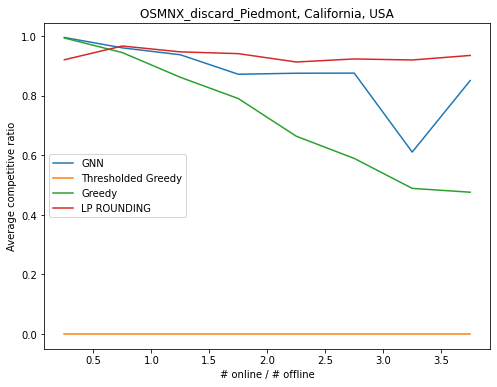

In [34]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
print(ratios)
for city, comp_ratios in data.items():
    greedy_avg_ratios = []
    thresholded_greedy_avg_ratios = []
    gnn_avg_ratios = []
    lp_match_avg_ratios = []


    for trial_ratios in comp_ratios:
        gnn_avg_ratios.append(np.array(trial_ratios[0]).mean())
        thresholded_greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[2]).mean())
        lp_match_avg_ratios.append(np.array(trial_ratios[3]).mean())
        

    title = f"OSMNX_discard_{city}"
    fig = plt.figure(figsize=(8,6))
    plt.title(title)
    plt.plot(ratios, gnn_avg_ratios, label='GNN')
    plt.plot(ratios, thresholded_greedy_avg_ratios, label='Thresholded Greedy')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, lp_match_avg_ratios, label='LP ROUNDING')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.savefig(f"data/{title}.png")
    plt.show()



FEAT_only_ratings_0.75


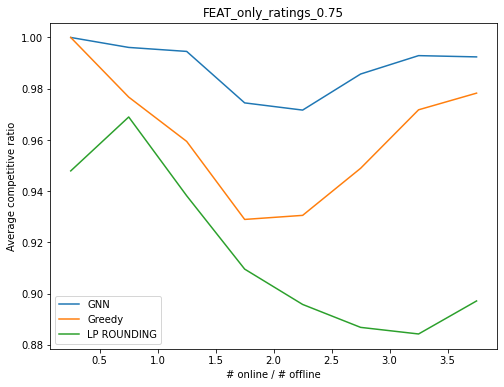

In [28]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
for q, comp_ratios in data.items():
    greedy_avg_ratios = []
    gnn_avg_ratios = []
    lp_match_avg_ratios = []


    for trial_ratios in comp_ratios:
        gnn_avg_ratios.append(np.array(trial_ratios[0]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[1]).mean())
        lp_match_avg_ratios.append(np.array(trial_ratios[2]).mean())

    # title = f"PART_size_{size}"
    title = f"FEAT_only_ratings_{q}"
    print(title)
    fig = plt.figure(figsize=(8,6))
    plt.title(title)
    plt.plot(ratios, gnn_avg_ratios, label='GNN')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, lp_match_avg_ratios, label='LP ROUNDING')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    # plt.savefig(f"data/{title}.png")
    plt.show()
